In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer
import lightgbm as lgb

In [32]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
df = pd.read_csv('data.tsv', sep='\t')

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [77]:
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [78]:
df['sentiment_label'].value_counts()

4    80000
0    80000
Name: sentiment_label, dtype: int64

In [79]:
pattern = r'https?://[^\s]+|www\.[^\s]+|\.[a-z]{2,}'
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(pattern, ' ', x).lower())

In [81]:
pattern = r'[^a-zA-Z0-9\s]'
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(pattern, '', x))

In [88]:
pattern = r'(.)\1{2,}'
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(pattern, r'\1\1', x))

In [83]:
lemmatizer = WordNetLemmatizer()

In [84]:
def lemm(text):
    words = word_tokenize(text)
    lemm_words = [lemmatizer.lemmatize(word) for word in words]
    return lemm_words

In [85]:
df['tweet_text'] = df['tweet_text'].apply(lemm)

In [86]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join(x))

for i in df.iterrows():
    print(i[1][1])

In [90]:
df['sentiment_label'] = df['sentiment_label'].apply(lambda x: 1 if x == 4 else 0)

In [91]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [92]:
tfidf_vectorizer = TfidfVectorizer()

In [93]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [94]:
regressor = LogisticRegression()

In [95]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_prob = regressor.predict_proba(X_test)[:, 1]

In [96]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred), "\n\nROC:", roc_auc_score(y_test, y_pred), "\n\nClassification report:\n", classification_report(y_test, y_pred))



Accuracy: 0.78590625 

ROC: 0.7859069146235456 

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78     16002
           1       0.78      0.79      0.79     15998

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



In [97]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [98]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 100,
}

In [99]:
model_lgb = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=500, callbacks=[lgb.early_stopping(stopping_rounds=50)])
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.670799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208420
[LightGBM] [Info] Number of data points in the train set: 128000, number of used features: 4321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	training's binary_logloss: 0.364439	valid_1's binary_logloss: 0.454697


In [100]:
y_pred_binary = (y_pred >= 0.5).astype(int)

In [103]:
def train_and_predict(params, train_data, test_data):
    
    model_lgb = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=500, callbacks=[lgb.early_stopping(stopping_rounds=50)])

    y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

    y_pred_binary = (y_pred >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)

    return (accuracy, roc_auc, y_test, y_pred)

In [104]:
stats = []

for leaves in range(40, 151, 20):
    for learning in range(10, 301, 50):
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'learning_rate': learning/1000,
            'num_leaves': leaves,
        }

        acc, roc, y_test, y_pred = train_and_predict(params, train_data, test_data)

        stats.append([leaves, learning, acc, roc])


[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.798476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208420
[LightGBM] [Info] Number of data points in the train set: 128000, number of used features: 4321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.511789	valid_1's binary_logloss: 0.520198
[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.607969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

In [106]:
s1 = pd.DataFrame(stats.copy())
s1.columns = ['num_leaves', 'learning_rate', 'accuracy', 'roc']
s1['learning_rate'] = s1['learning_rate'] / 1000

In [108]:
s1.sort_values('accuracy', ascending=False).head()

,num_leaves,learning_rate,accuracy,roc
25,120,0.06,0.789312,0.868390
32,140,0.11,0.788438,0.867642
14,80,0.11,0.788062,0.868019
31,140,0.06,0.788031,0.868572
19,100,0.06,0.787750,0.868156


In [109]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.06,
    'num_leaves': 120,
}
accuracy, roc_auc, y_test, y_pred = train_and_predict(params, train_data, test_data)

[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.683233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208420
[LightGBM] [Info] Number of data points in the train set: 128000, number of used features: 4321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.347468	valid_1's binary_logloss: 0.454397


In [110]:
y_pred_binary = (y_pred >= 0.5).astype(int)

In [111]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred_binary), "\n\nROC:", roc_auc_score(y_test, y_pred), "\n\nClassification report:\n", classification_report(y_test, y_pred_binary))



Accuracy: 0.7893125 

ROC: 0.868389958881093 

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79     16002
           1       0.79      0.79      0.79     15998

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



In [112]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

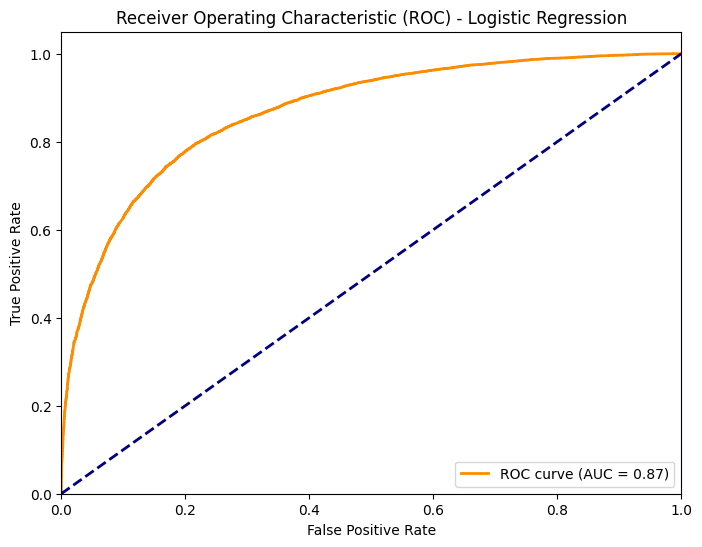

In [114]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('plots\\roc_lightgbm.png', dpi=300)
plt.show()

In [263]:
tokenizer = Tokenizer(num_words=10000)

In [264]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [265]:
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [266]:
max_length = 50

In [268]:
X_train_seq = pad_sequences(X_train_seq, maxlen=max_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length)

In [269]:
X_train_seq = np.array(X_train_seq)
X_test_seq = np.array(X_test_seq)

In [270]:
y_train = np.array(y_train.tolist())
y_test = np.array(y_test.tolist())

In [271]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)

In [272]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=50, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [273]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [274]:
model.fit(X_train_seq, y_train, epochs=10, batch_size=10, verbose=1, validation_data=(X_test_seq, y_test), callbacks=[early_stopping])

Epoch 1/10
12800/12800 [==============================] - 53s 4ms/step - loss: 0.4952 - accuracy: 0.7633 - val_loss: 0.4696 - val_accuracy: 0.7818
Epoch 2/10
12800/12800 [==============================] - 52s 4ms/step - loss: 0.4195 - accuracy: 0.8124 - val_loss: 0.4877 - val_accuracy: 0.7762
Epoch 3/10
12800/12800 [==============================] - 52s 4ms/step - loss: 0.3453 - accuracy: 0.8533 - val_loss: 0.5384 - val_accuracy: 0.7631
Epoch 4/10
12800/12800 [==============================] - 53s 4ms/step - loss: 0.2840 - accuracy: 0.8825 - val_loss: 0.6102 - val_accuracy: 0.7502
Epoch 5/10
12800/12800 [==============================] - 52s 4ms/step - loss: 0.2430 - accuracy: 0.9014 - val_loss: 0.6842 - val_accuracy: 0.7454
Epoch 6/10
12800/12800 [==============================] - 51s 4ms/step - loss: 0.2154 - accuracy: 0.9129 - val_loss: 0.7595 - val_accuracy: 0.7343
Epoch 7/10
12800/12800 [==============================] - 51s 4ms/step - loss: 0.1947 - accuracy: 0.9212 - val_loss: 0

In [115]:
max_length = 128
max_features = 30522

In [116]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [117]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_encoded = [tokenizer.encode(text, add_special_tokens=True) for text in X_train]
X_test_encoded = [tokenizer.encode(text, add_special_tokens=True) for text in X_test]

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')


tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<?, ?B/s]
c:\Users\fredd\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fredd\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.txt: 100%|██████████|

In [118]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)


In [119]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_length, mask_zero=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

In [120]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [121]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [122]:
history = model.fit(train_dataset, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

Epoch 1/10


4000/4000 [==============================] - 284s 70ms/step - loss: 0.4782 - accuracy: 0.7709 - val_loss: 0.4411 - val_accuracy: 0.7952
Epoch 2/10
4000/4000 [==============================] - 277s 69ms/step - loss: 0.3891 - accuracy: 0.8235 - val_loss: 0.4539 - val_accuracy: 0.7913
Epoch 3/10
4000/4000 [==============================] - 277s 69ms/step - loss: 0.3023 - accuracy: 0.8705 - val_loss: 0.5418 - val_accuracy: 0.7758
Epoch 4/10
4000/4000 [==============================] - 277s 69ms/step - loss: 0.2188 - accuracy: 0.9115 - val_loss: 0.6680 - val_accuracy: 0.7602
Epoch 4: early stopping


In [123]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)

1000/1000 - 12s - loss: 0.4411 - accuracy: 0.7952 - 12s/epoch - 12ms/step


In [124]:
predictions = model.predict(X_test_padded)

1000/1000 [==============================] - 14s 13ms/step


In [125]:
y_pred_binary = (predictions >= 0.5).astype(int)

In [126]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred_binary), "\n\nROC:", roc_auc_score(y_test, predictions), "\n\nClassification report:\n", classification_report(y_test, y_pred_binary))



Accuracy: 0.79521875 

ROC: 0.8767174316674599 

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80     16002
           1       0.80      0.79      0.79     15998

    accuracy                           0.80     32000
   macro avg       0.80      0.80      0.80     32000
weighted avg       0.80      0.80      0.80     32000



In [127]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

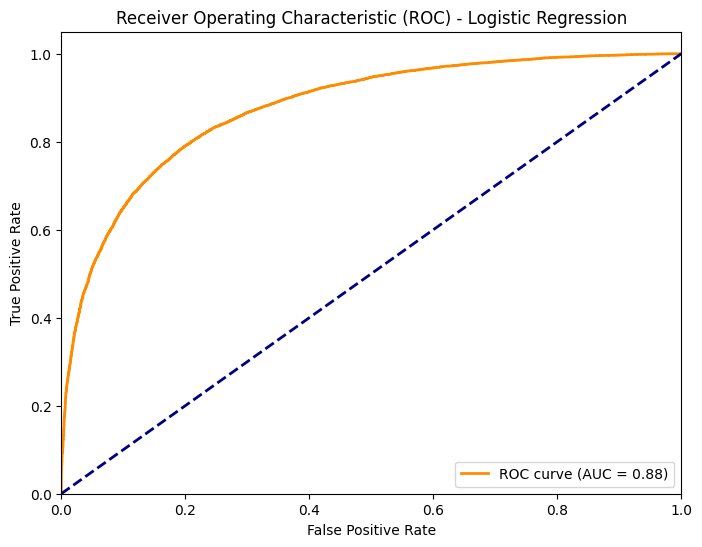

In [128]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('plots\\roc_nn.png', dpi=300)
plt.show()